# Analysis of online music store sales using SQL

## Introduction

In this project, we'll do an exploratory analysis of an online music store data. The database with which we'll be working is a modified version of the [Chinook database](https://github.com/lerocha/chinook-database). Chinook is a fictional digital music shop, in some aspects similar to iTunes.

In our analysis we'll answer the following questions:

**Q1:** What albums should be prioritized to be added to the store from a list of new titles?

**Q2:** Is any sales support agent performing better than others and why?

**Q3:** In what countries should Chinook increase sales?

**Q4:** Should Chinook change their purchasing strategy?


## Getting Familiar with the data

The Chinook database contains eleven tables with information about:
- the artists, songs, and albums from the music shop
- shop's employees, customers, and the customers purchases


The schema diagram for the Chinook database:

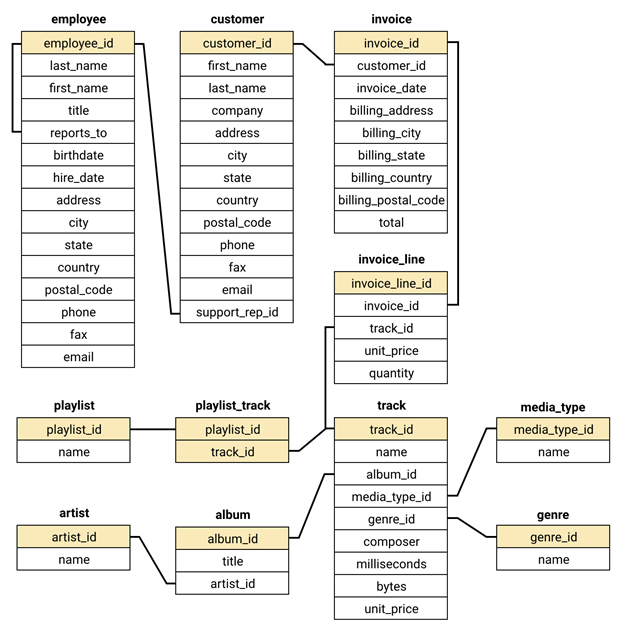


Let's set up the environment for working with an SQLite database and get familiar with the data.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


All the tables from the schema are present in the database. Let's start answering the questions.

## Q1: What albums should be prioritized to be added to the store from a list of new titles?

**Background:** The Chinook record store has just signed a deal with a new record label. The task is to select for listing three albums out of proposed four. All the albums are by artists that don't have any tracks in the store right now - we have the artists' names, and the genres of music they produce:

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |


The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

**Solution with SQL:** Let's write a request that will return the number of tracks sold in the US by each genre. With this information, we'll be able to select the three new albums based on their genre popularity.

In [3]:
%%sql
WITH cgs AS
    (
    SELECT
        i.billing_country country,
        g.name genre,
        SUM(il.unit_price * il.quantity) sales
    FROM invoice_line il
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
    GROUP BY 1,2
    ORDER BY 1,3 DESC
    ),
    cs AS
    (
    SELECT
        country,
        sum(sales) total_country_sales
    FROM cgs
    GROUP BY 1
    )

SELECT
    cgs.genre 'Genre',
    ROUND(cgs.sales, 1) 'Country Sales',
    ROUND(
          sales / total_country_sales * 100, 1
         ) 'Country Sales, %'
FROM cgs
LEFT JOIN cs on cs.country = cgs.country
WHERE cgs.country = "USA"

 * sqlite:///chinook.db
Done.


Genre,Country Sales,"Country Sales, %"
Rock,555.4,53.4
Alternative & Punk,128.7,12.4
Metal,122.8,11.8
R&B/Soul,52.5,5.0
Blues,35.6,3.4
Alternative,34.6,3.3
Pop,21.8,2.1
Latin,21.8,2.1
Hip Hop/Rap,19.8,1.9
Jazz,13.9,1.3


**Answer:** based on the numbers above, if we should pick Punk, Blues and Pop genres because they have higher sales than Hip-Hop in the US. The artits'names are:

- Red Tone;
- Slim Jim Bites;
- Meteor and the Girls.


## Q2: Is any sales support agent performing better than others and why?

**Background:** Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We want to rank sales support agents by their performance and find what might be a reason for performance variation.

**Solution with SQL:** Let's write a request to get a table with support agents, their hire dates, total sales, number of customers and sales per customer.

In [4]:
%%sql

WITH ec AS
    (
    SELECT
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        date(e.hire_date) hire_date, 
        ROUND(SUM(total), 2) total_sales
    FROM invoice i
    LEFT JOIN customer c on c.customer_id = i.customer_id
    LEFT JOIN employee e on e.employee_id = c.support_rep_id
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    ),
    e_cc AS
    (
    SELECT
        support_rep_id,
        count(customer_id) num_customers
    FROM customer
    GROUP BY 1
    )

SELECT 
    employee_name,
    hire_date,
    total_sales,
    num_customers,
    ROUND(
        (ec.total_sales / e_cc.num_customers),
        2
         ) sales_per_customer 
FROM ec
LEFT JOIN e_cc on ec.employee_id = e_cc.support_rep_id

 * sqlite:///chinook.db
Done.


employee_name,hire_date,total_sales,num_customers,sales_per_customer
Jane Peacock,2017-04-01,1731.51,21,82.45
Margaret Park,2017-05-03,1584.0,20,79.2
Steve Johnson,2017-10-17,1393.92,18,77.44


**Answer:** From the table above, we see that Jane Peacock was the first support agent. She had the highest total sales and the number of customers assigned to her. Overall, we see that the longer an employee had worked in the company, the more customers they served and the more sales they generated. The effeciency also rose with the increase of employee's experience.

## Q3: In what countries should Chinook increase sales?

**Background:** We want to understand what countries have the highest opportunity for generating more sales in the future. 

**Solution with SQL:** Let's calculate the following measurements by country.

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

There is a number of countries that have only one customer. We will aggregate them as the 'Other' category. We will order the countries by their total sales from highest to lowest, keeping 'Other' at the very bottom.

In [5]:
%%sql

WITH
    cc_sales AS
        (
        SELECT
            c.country country,
            i.customer_id customer_id,
            sum(i.total) total_sales,
            count(i.invoice_id) total_sales_count
        FROM invoice i
        LEFT JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY 1, 2
        ORDER BY total_sales DESC
        ),
    c_cust AS
        (
        SELECT
            country,
            COUNT(customer_id) num_cust
        FROM customer
        GROUP BY country
        ORDER BY num_cust DESC
        )

SELECT
    country,
    total_sales,
    customers,
    orders,
    avg_cust_sales,
    avg_order
FROM
    (
    SELECT
        CASE
        WHEN c_cust.num_cust > 1
        THEN 0
        ELSE 1
        END AS sort,
        
        CASE
        WHEN c_cust.num_cust > 1
        THEN cc_sales.country
        ELSE
            "Other"
        END AS country,
    
        
        ROUND(sum(total_sales), 2) total_sales,
        CASE
        WHEN c_cust.num_cust > 1
        THEN c_cust.num_cust
        ELSE SUM(c_cust.num_cust)
        END AS customers,
        SUM(total_sales_count) orders,
        ROUND(AVG(total_sales), 2) avg_cust_sales,
        ROUND(SUM(total_sales) / SUM(total_sales_count),
              2) avg_order
        
    FROM cc_sales
    LEFT JOIN c_cust ON c_cust.country = cc_sales.country
    GROUP BY 2
    )
ORDER BY sort ASC, total_sales DESC

 * sqlite:///chinook.db
Done.


country,total_sales,customers,orders,avg_cust_sales,avg_order
USA,1040.49,13,131,80.04,7.94
Canada,535.59,8,76,66.95,7.05
Brazil,427.68,5,61,85.54,7.01
France,389.07,5,50,77.81,7.78
Germany,334.62,4,41,83.66,8.16
Czech Republic,273.24,2,30,136.62,9.11
United Kingdom,245.52,3,28,81.84,8.77
Portugal,185.13,2,29,92.57,6.38
India,183.15,2,21,91.58,8.72
Other,1094.94,15,147,73.0,7.45


**Answer:** Czech Republic, United Kingdom and India do not have big total sales; however, they show one of the highest numbers in average order and average sales per customer. There might be a potential in these countries.

It's worth keeping in mind that the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these measurements stay at the level that is higher than other countries'.

## Q4: Should Chinook change their purchasing strategy?

**Background:** The Chinook store is set up in a way that allows customer to make purchases in one of the two ways:
•	purchase a whole album
•	purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

**Solution with SQL:** Let's find what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

There are 2 edge cases:

 - Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
 - Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In [6]:
%%sql
WITH
    ita AS
    (
    SELECT
        il.invoice_id invoice_id,
        min(il.track_id) track_id,
        t.album_id album_id
    FROM invoice_line il
    LEFT JOIN track t on t.track_id = il.track_id
    GROUP BY 1
    ),
    finale AS
    (
    SELECT
    ita.invoice_id,
    CASE WHEN
    (
        SELECT t.track_id FROM track t
        WHERE t.album_id = ita.album_id

        EXCEPT

        SELECT il.track_id FROM invoice_line il
        WHERE il.invoice_id = ita.invoice_id
    ) is NULL
    AND
    (
        SELECT il.track_id FROM invoice_line il
        WHERE il.invoice_id = ita.invoice_id
        
        EXCEPT
        
        SELECT t.track_id FROM track t
        WHERE t.album_id = ita.album_id
    )
    is NULL THEN "ALBUM PURCHASE"
    ELSE "SONGS PURCHASE" END AS purch_type
    FROM ita
    )

SELECT
    purch_type,
    COUNT(invoice_id) num_puchases,
    ROUND(CAST(count(invoice_id) AS FLOAT)/CAST((SELECT COUNT(*) FROM invoice) AS FLOAT),
          2) share
FROM finale    
GROUP BY 1

 * sqlite:///chinook.db
Done.


purch_type,num_puchases,share
ALBUM PURCHASE,114,0.19
SONGS PURCHASE,500,0.81


**Answer:** We see that 19% of orders are for full albums. It would not be a good recomendation to lose almost 20% of sales. Therefore, the company should not change it's strategy in that aspect. However, a good next step would be to inspect if there are features that make some albums to be purchased more frequently in full, and others - more frequently partially (just some top tracks). Then the company could use a predictive model for recommending whether to purchase the whole album, or only some tracks. However, this approach should be carefully assessed on negative effect on the company's market share.

## Conclusion

In this project, we used SQL requests to answer four business questions and were able to give recomendations to the company based on the data.

**Q1:** What albums should be prioritized to be added to the store from a list of new titles?
<br>**A1:** The albums by Red Tone, Slim Jim Bites, and Meteor and the Girls.

**Q2:** Is any sales support agent performing better than others and why?
<br>**A2:** In general, the agents'effeciency rose with the increase of their experience.

**Q3:** In what countries should Chinook increase sales?
<br>**A3:** Czech Republic, United Kingdom and India show potential for generating higher sales. Small scale pilots in these countries are recommended to prove this hypothesis.

**Q4:** Should Chinook change their purchasing strategy?
<br>**A4:** The company should not change their strategy on purchasing only individual tracks from albums because purchases of full albums amount to 19% of total sales.